<a href="https://colab.research.google.com/github/Erifai/Bi_Project/blob/main/Projet_BI_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Préparation de l'environnement :**

In [ ]:
#!pip install -U spacy 
#!pip install spacy-transformers
#!pip install spacy_entity_linker
#!python3 -m spacy_entity_linker "download_knowledge_base"
#!python -m spacy download en_core_web_sm
#!pip install -U sentence-transformers
#!sudo apt-get install metis
#!pip install Cluster_Ensembles

#à executer une seule fois et de redémarrer le runtime avec GPU 

In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re
import operator
from functools import reduce
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **PARTIE 1 :**

In [21]:
#df = pd.read_fwf('/content/DBLP_Subset.txt')
#df=pd.read_table('/content/DBLP_Subset.txt',header=None)
#df = pd.read_csv("/content/DBLP_Subset.txt",sep="\n")
reading_file = open("/content/DBLP_Subset.txt", "r")

new_file_content = ""
count = 0
count_auth = 0
for line in reading_file:

  stripped_line = line.strip()

  new_line = stripped_line.replace(';',',')
  if "#t" in new_line :
    count_auth = 0
  if "#!" in new_line :
    count=0
  if "#@" in new_line :
    count_auth = 1
  new_line = new_line.replace('#c',';').replace('#*','\n;').replace('#c',';').replace('#t',';').replace('#index',';').replace('#!',';').replace('#@',';')
  if "#%" in new_line and count==0 :
    #print(new_line)
    new_line = new_line.replace('#%',';')
    #print(new_line)

    count =1
  if count_auth == 1 :
    new_line = new_line + ","   

  new_file_content += new_line


reading_file.close()
df = pd.DataFrame([x.split(';') for x in new_file_content.split('\n')])
# .replace('#c',';').replace('#*',';').replace('#c%',';').replace('#t',';').replace('#index',';').replace('#!',';')
#   df = pd.DataFrame([x.split(';') for x in lines.split('\n')])

In [22]:
df.rename(columns={0:"supprimer",1:"Titre",2:"Auteurs",3:"Année",4:"Revue",5:"IndexId",6:"IdRefrences",7:"Abstract"},inplace= True)
df.drop(columns=['supprimer'],inplace= True)
df.dropna(inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17852 entries, 1 to 37963
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Titre        17852 non-null  object
 1   Auteurs      17852 non-null  object
 2   Année        17852 non-null  object
 3   Revue        17852 non-null  object
 4   IndexId      17852 non-null  object
 5   IdRefrences  17852 non-null  object
 6   Abstract     17852 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [23]:
li = df['Revue'].value_counts()


In [24]:
list_revue = []
for i in range(0,len(li)-1):
  if(li[i] >= 50):
    list_revue.append(li.index[i])
  else:
    break


In [25]:
df_revue = pd.DataFrame(list_revue)
dff= pd.merge(df,df_revue,how='inner',left_on=['Revue'],right_on=[0])
dff.drop(columns=[0],inplace=True)
df = dff
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17429 entries, 0 to 17428
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Titre        17429 non-null  object
 1   Auteurs      17429 non-null  object
 2   Année        17429 non-null  object
 3   Revue        17429 non-null  object
 4   IndexId      17429 non-null  object
 5   IdRefrences  17429 non-null  object
 6   Abstract     17429 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [26]:
df['Revue'].value_counts()

DAC                                  2010
Electr. Notes Theor. Comput. Sci.    1891
IJCAI                                1891
ICCAD                                1666
SIGMOD Conference                    1529
GECCO                                1472
Discrete Applied Mathematics         1328
Journal of Systems and Software       899
ICIP                                  812
Des. Codes Cryptography               648
ICC                                   587
SIGMOD Record                         510
SMC                                   325
GECCO (Companion)                     269
Distributed Computing                 214
DATA BASE                             204
Data Min. Knowl. Discov.              175
ICCSA (1)                             152
ICCSA (2)                             145
ICCSA (3)                             144
IJCAI (1)                              82
ICCV                                   76
STOC                                   72
ICCBR                             

# PARTIE 2 :

les auteurs les plus productifs :

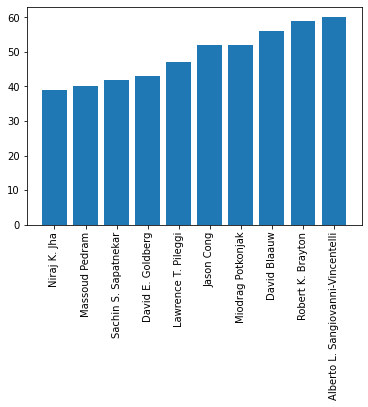

In [28]:
dict_authers = {}
def auth(x):
  li = x.split(",")
  for auth in li:
    if auth in dict_authers.keys():
      dict_authers.update({auth : dict_authers[auth] + 1})
    else:
      dict_authers[auth] = 1

df['Auteurs'].map(lambda x : auth(x))
dict_authers.pop('')
dict_auth_ord = dict(sorted(dict_authers.items(), key=lambda item: item[1]))

height = list(dict_auth_ord.keys())
height = height[-10:]
bars = list(dict_auth_ord.values())
bars = bars[-10:]
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 90
plt.xticks(y_pos, height,rotation = degrees )
# Show graphic
plt.show()

les articles les plus populaires :

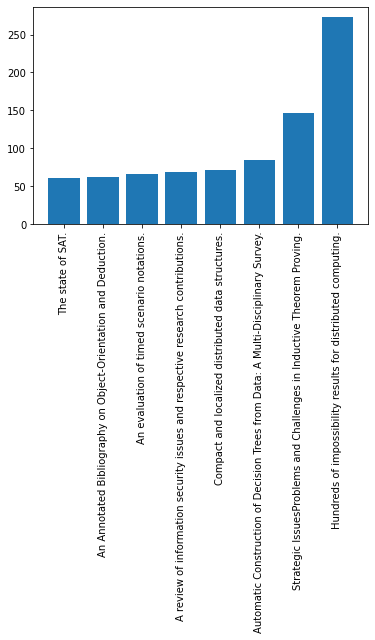

In [27]:
df['nombre_citation'] = df['IdRefrences'].map(lambda x : len(x.split("#")))

lii = df['nombre_citation'].to_list()
lii.sort()
list_nb_citation = lii[-8:]

list_abs = []
for i in list_nb_citation:
  ind = df[df['nombre_citation'] == i].index
  list_abs.append(df.at[ind[0],"Titre"])

height = list_abs
bars = list_nb_citation
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 90
plt.xticks(y_pos, height,rotation = degrees )
# Show graphic
plt.show()


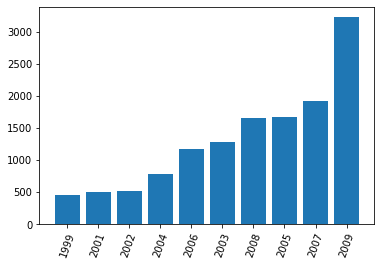

In [67]:
dff = df.groupby(['Année'])['Année'].count()
dff = dff.sort_values()
list_ind_annee = dff[-10:]
list_annee = []
for i in list_ind_annee:
  list_annee.append(dff[dff == i].index[0])

list_annee

height = list_annee
bars = list_ind_annee
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 70
plt.xticks(y_pos, height,rotation = degrees )
# Show graphic
plt.show()

 Distribution du nombre d’articles par revue/conférence :

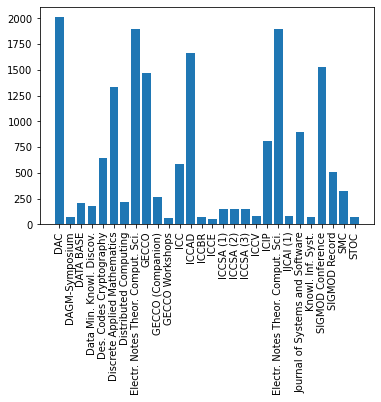

In [71]:
dff = df.groupby(['Revue'])['Année'].count()

list_revue = []
for i in dff:
  list_revue.append(dff[dff == i].index[0])

list_revue

height = list_revue
bars = dff
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 90
plt.xticks(y_pos, height,rotation = degrees )
# Show graphic
plt.show()

Distribution du nombre de citations :

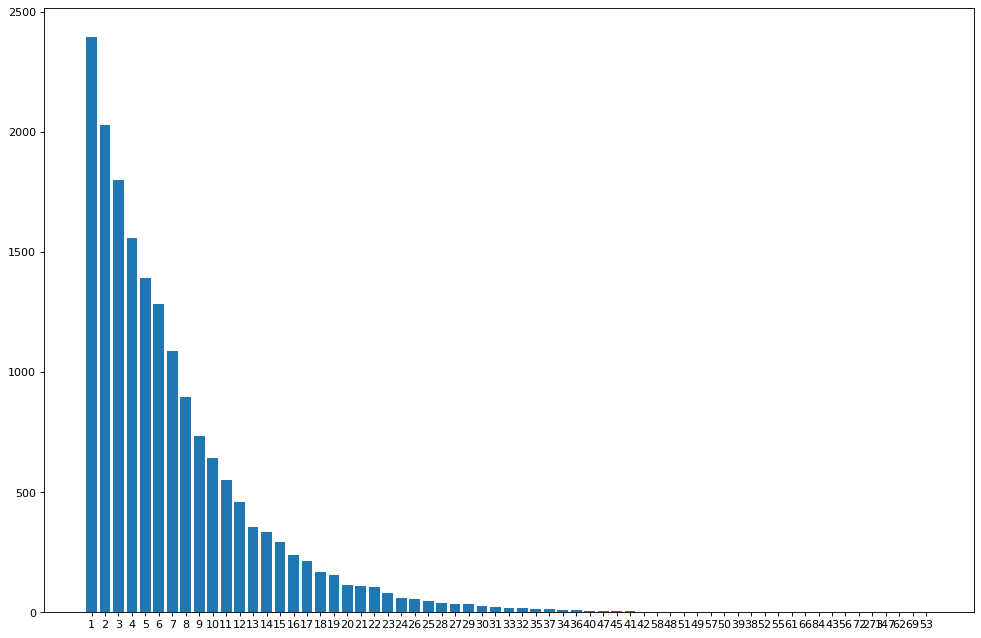

In [89]:
li = df['nombre_citation'].value_counts()

from matplotlib.pyplot import figure

figure(figsize=(15, 10), dpi=80)
height = list(li.keys())
bars = li
y_pos = np.arange(len(bars))
# Create bars
plt.bar(y_pos, bars)
# Create names on the x-axis
degrees = 0
plt.xticks(y_pos, height,rotation = degrees)
# Show graphic
plt.show()



In [90]:
#punctuations
punctuations = string.punctuation
#stopwords
stop_words = list(STOP_WORDS)
def clean_text(
  string : str,
  ponctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
  stop_words = stop_words)->str : 

  #URLs
  string = re.sub(r"https?://\S+|www\.\S+",'',string)
  #html 
  string = re.sub(r'<.*?>','',string)
  #Numbers
  string = re.sub(r'[0-9]+','',string) 

  #Remove punctuations
  for x in string.lower():
    if x in punctuations:
      string = string.replace(x,"")
  #To lower
  string = string.lower()
  #Remove stop words
  lemmatizer = WordNetLemmatizer()
  string = ' '.join([lemmatizer.lemmatize(word) for word in string.split() if word not in stop_words])
  #Cleaning the whitespaces
  string = re.sub(r'\s', ' ', string).strip()

  return string
  


In [91]:
from sklearn.feature_extraction.text import CountVectorizer
abstract = df.Abstract.to_list()
abstracts_cleaned = [clean_text(x) for x in abstract]
len(abstracts_cleaned)

17429

In [94]:
from collections import Counter
cnt = Counter()
for text in abstracts_cleaned:
    for word in text.split():
        cnt[word] += 1


In [93]:
cnt.most_common(30)

[('algorithm', 11380),
 ('system', 11285),
 ('problem', 9950),
 ('model', 8898),
 ('paper', 8652),
 ('data', 8258),
 ('result', 8024),
 ('method', 7353),
 ('approach', 7060),
 ('based', 5961),
 ('design', 5933),
 ('present', 5678),
 ('set', 5437),
 ('technique', 5349),
 ('new', 5298),
 ('time', 4830),
 ('proposed', 4766),
 ('performance', 4700),
 ('application', 4285),
 ('number', 4212),
 ('network', 4175),
 ('graph', 4060),
 ('query', 3793),
 ('use', 3740),
 ('information', 3687),
 ('process', 3460),
 ('analysis', 3433),
 ('function', 3336),
 ('solution', 3295),
 ('circuit', 3218)]

# **PARTIE 3 :**

# **Transformation de données :**

## **Vectorisation (Document - mot )**

In [98]:
from random import sample
df = df.sample(frac=0.5)

abstract = df.Abstract.to_list()
abstracts_cleaned = [clean_text(x) for x in abstract]
len(abstracts_cleaned)


8714

In [102]:
vectorizer = CountVectorizer()
DocTerm_abstract = vectorizer.fit_transform(abstracts_cleaned)
print('type of DocTerm_abstract : ', type(DocTerm_abstract))
print("Documents / Mots  : ",DocTerm_abstract.shape)
print(DocTerm_abstract)

DocTerm_abstract = DocTerm_abstract.toarray()
print("******************************************")
print('DocTerm_abstract', type(DocTerm_abstract))


type of DocTerm_abstract :  <class 'scipy.sparse.csr.csr_matrix'>
Documents / Mots  :  (8714, 52380)
  (0, 22687)	1
  (0, 45919)	1
  (0, 8103)	1
  (0, 11963)	1
  (0, 35711)	4
  (0, 43144)	1
  (0, 19665)	1
  (0, 22660)	1
  (0, 27173)	1
  (0, 12767)	1
  (0, 12310)	1
  (0, 30859)	1
  (0, 3287)	1
  (0, 17026)	1
  (0, 19887)	1
  (0, 32173)	1
  (0, 10660)	1
  (0, 41567)	1
  (0, 7892)	2
  (0, 33087)	1
  (0, 7823)	1
  (0, 6911)	2
  (0, 44398)	2
  (0, 41563)	1
  (0, 17191)	1
  :	:
  (8713, 41309)	1
  (8713, 457)	1
  (8713, 29819)	5
  (8713, 11407)	1
  (8713, 11036)	1
  (8713, 42283)	1
  (8713, 14061)	1
  (8713, 15037)	1
  (8713, 39311)	1
  (8713, 6519)	1
  (8713, 31895)	1
  (8713, 311)	1
  (8713, 44581)	1
  (8713, 32929)	1
  (8713, 15700)	1
  (8713, 24736)	1
  (8713, 38201)	1
  (8713, 49598)	1
  (8713, 14213)	1
  (8713, 48939)	1
  (8713, 45676)	1
  (8713, 14725)	1
  (8713, 4375)	1
  (8713, 47823)	3
  (8713, 42530)	1
******************************************
DocTerm_abstract <class 'numpy.ndarr

## **Exctraction de "Linked entities"**

In [ ]:
import spacy
import en_core_web_sm
from functools import reduce
nlp = spacy.load('en_core_web_sm')
# add pipeline (declared through entry_points in setup.py)
nlp.add_pipe("entityLinker",last=True)

In [ ]:
listEntity =[]
for a,abs in enumerate(abstracts_cleaned):
  doc = nlp(str(abs))
  listInter=[]
  #return all the entities in the whole document
  all_linked_entities = doc._.linkedEntities
  #itereate over sentences and print linked entities
  for sent in doc.sents:
    #print(sent._.linkedEntities)
    for i in range(len(sent._.linkedEntities)):
      entity = sent._.linkedEntities[i].get_id()
      listInter.append(entity)
  listEntity.append(listInter)


In [ ]:
listEntityAll = reduce(operator.concat,listEntity)
print("listEntityAll" , len(listEntityAll))
listEntityAllunique = np.unique(np.asarray(listEntityAll))
print("listEntityAllunique" , len(listEntityAllunique))


listEntityAll 1682
listEntityAllunique 566


## **Document - Entité**

In [ ]:
dictindex = dict(zip(listEntityAllunique,np.arange(len(listEntityAllunique))))
entityEmbedding = np.zeros((len(abstract),len(listEntityAllunique)))
for a in range(len(abstract)):
  lista = listEntity[a]
  indexEn = values = np.asanyarray(list(map(dictindex.get,lista)))
  entityEmbedding[a,indexEn]=1

## **BERT**

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')
sentence_embedding = model.encode(abstract)

In [ ]:
sentence_embedding

array([[-0.90498275,  0.20419133,  0.54003567, ...,  0.1595102 ,
        -0.02890011,  0.21780182],
       [-0.84162533,  0.37580818,  0.31556702, ..., -0.15957555,
        -0.1251584 ,  0.36724833],
       [-0.0920645 ,  0.60817575,  0.5032281 , ..., -0.46368083,
        -1.1678922 ,  0.628837  ],
       ...,
       [-0.8522707 ,  0.6357087 ,  0.32293302, ..., -0.90342045,
        -0.16440001,  0.16181709],
       [-0.15328439,  0.30836326,  1.0114954 , ..., -0.23881237,
        -0.5476271 ,  0.27469596],
       [-0.00146912,  0.23846017,  0.8166513 , ..., -0.25199023,
        -1.2100103 ,  0.4056557 ]], dtype=float32)

# **Clustering**

In [105]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

K=28
labels_all, u  = pd.factorize(df['Revue'])

kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(DocTerm_abstract)
y_pred1 = kmeans.labels_
print(y_pred1)
print('Bow representation clustering  accuracy : ',accuracy_score(labels_all,y_pred1))

[10 15 15 ... 15 12 15]
Bow representation clustering  accuracy :  0.0330502639430801


In [103]:
labels_all, a = pd.factorize(df['Revue'])
print(labels_all.)


[ 0  1  1 ...  3 10 10]


In [104]:
np.unique(labels_all)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [ ]:
kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(entityEmbedding)
#kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(mat)

y_pred2 = kmeans.labels_
print(y_pred2)
#print('Entity  representation clustering  accuracy : ',accuracy_score(labels_all,y_pred2))

In [ ]:
kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(sentence_embedding)
y_pred3 = kmeans.labels_
print(y_pred3)
#print('Sentence  representation clustering  accuracy : ',accuracy_score(labels_all,y_pred3))